In [1]:
import datamol as dm
from splito import ScaffoldSplit


Get freesolv dataset and make splits

In [2]:
df = dm.data.freesolv()
X, y = df["smiles"], df["expt"]
scaffold_splitter = ScaffoldSplit(X, n_splits=100, n_jobs=-1, train_size=0.8, test_size=0.2)
splits = scaffold_splitter.split(X)


In [3]:
# Non deterministic, wildly varies in number of points. Try and get a rough 90:10 split
train_idx, test_idx = next(splits)

while(len(train_idx)/(len(test_idx)+len(train_idx))>0.91 or len(train_idx)/(len(test_idx)+len(train_idx))<0.89):
    train_idx, test_idx = next(splits)

print(len(train_idx), len(test_idx), len(train_idx)/(len(test_idx)+len(train_idx)))

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

582 60 0.9065420560747663


# Scale and featurise data

In [ ]:
from molfeat.trans import MoleculeTransformer
from sklearn.preprocessing import StandardScaler


transformer = MoleculeTransformer(featurizer='desc2D', dtype=float, verbose=False)
scaler = StandardScaler()

X_train_features = transformer(X_train)

scaler.fit(X_train_features)

X_train_scaled=scaler.transform(X_train_features)

X_test_features = transformer(X_test)
X_test_scaled = scaler.transform(X_test_features)




# Train a random forest model

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor


# Cross validation for random forest model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=0, 
                               random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)



RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_squared_error')

Plot result and print metrics for best model

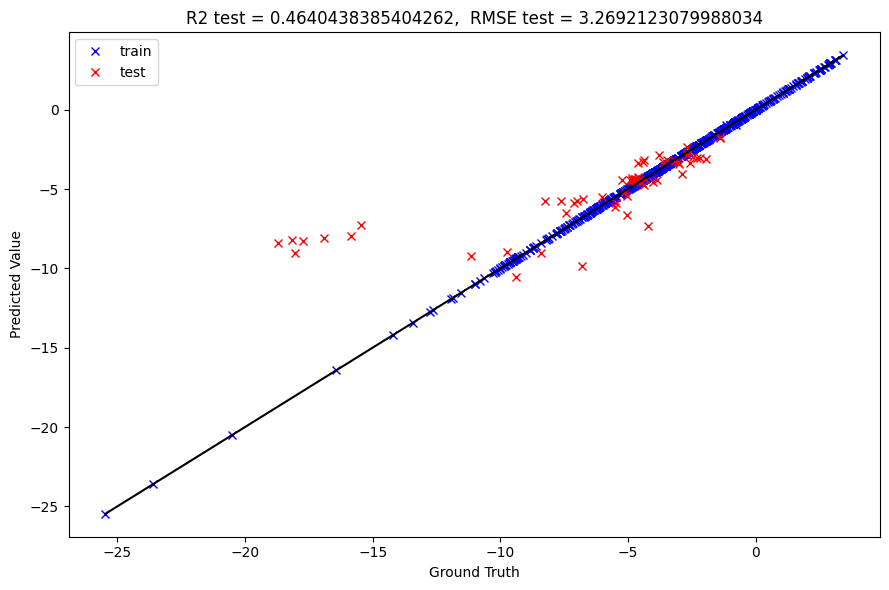

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

fig, ax = plt.subplots(figsize=(9,6))
y_train_predictions = rf_random.best_estimator_.predict(X_train_scaled)
y_test_predictions = rf_random.best_estimator_.predict(X_test_scaled)

test_r2 = r2_score(y_test,y_test_predictions)
test_rmse = root_mean_squared_error(y_test,y_test_predictions)

ax.plot(y_train, y_train_predictions, color = 'b', linestyle='', marker='x', label='train')
ax.plot(y_test, y_test_predictions, color = 'r', linestyle='', marker='x', label='test')

ax.set_xlabel('Ground Truth')
ax.set_ylabel('Predicted Value')
ax.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], color = 'k')
ax.set_title(f'R2 test = {test_r2},  RMSE test = {test_rmse}')
ax.legend(loc='best')
fig.tight_layout()
fig.show()
fig.savefig('best_rf_model.png',dpi=200)


Train XGBoostRegressor

In [7]:
from xgboost import XGBRegressor

eta = np.logspace(0.01,0.3,num=5, endpoint=True)
subsample = np.linspace(0.5, 1, num=6, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, num=6, endpoint=True)
max_depth = [3, 4, 5, 6, 7]
gamma = np.linspace(0,10,num=100)

random_grid= {
    'eta': eta,
    'colsample_bytree': colsample_bytree,
    'max_depth': max_depth,
    'subsample': subsample,
    'gamma': gamma,
}

xgbreg = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgbreg, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=0, 
                               random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')

# Fit the random search model
xgb_random.fit(X_train_scaled, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

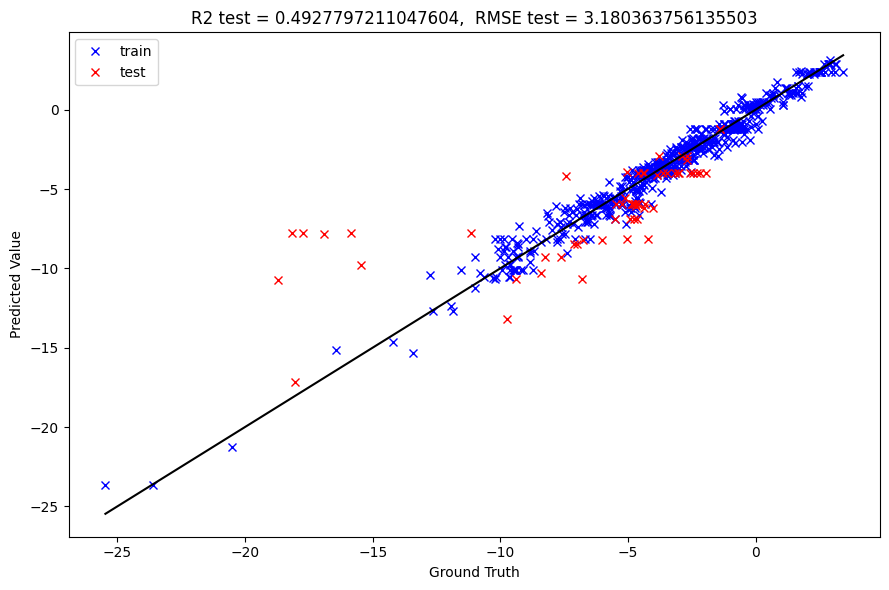

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
y_train_predictions = xgb_random.best_estimator_.predict(X_train_scaled)
y_test_predictions = xgb_random.best_estimator_.predict(X_test_scaled)

test_r2 = r2_score(y_test,y_test_predictions)
test_rmse = root_mean_squared_error(y_test,y_test_predictions)

ax.plot(y_train, y_train_predictions, color = 'b', linestyle='', marker='x', label='train')
ax.plot(y_test, y_test_predictions, color = 'r', linestyle='', marker='x', label='test')

ax.set_xlabel('Ground Truth')
ax.set_ylabel('Predicted Value')
ax.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], color = 'k')
ax.set_title(f'R2 test = {test_r2},  RMSE test = {test_rmse}')
ax.legend(loc='best')
fig.tight_layout()
fig.show()
fig.savefig('best_xgb_model.png',dpi=200)


Train Support Vector Regressor

In [9]:
from sklearn.svm import SVR

kernel = ['linear','poly','rbf']
degree = [3,4,5]
gamma = ['scale','auto'] 
epsilon = np.logspace(0.01,0.3, num = 6, endpoint=True)
C = np.linspace(0.1,1.0, num=6, endpoint=True)

random_grid= {
    'kernel': kernel,
    'degree': degree,
    'gamma': gamma,
    'epsilon': epsilon,
    'C': C,
}

svr = SVR()

svr_random = RandomizedSearchCV(estimator = svr, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=0, 
                               random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')

# Fit the random search model
svr_random.fit(X_train_scaled, y_train)


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=500, n_jobs=-1,
                   param_distributions={'C': array([0.1 , 0.28, 0.46, 0.64, 0.82, 1.  ]),
                                        'degree': [3, 4, 5],
                                        'epsilon': array([1.02329299, 1.16949939, 1.33659552, 1.52756606, 1.74582215,
       1.99526231]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error')

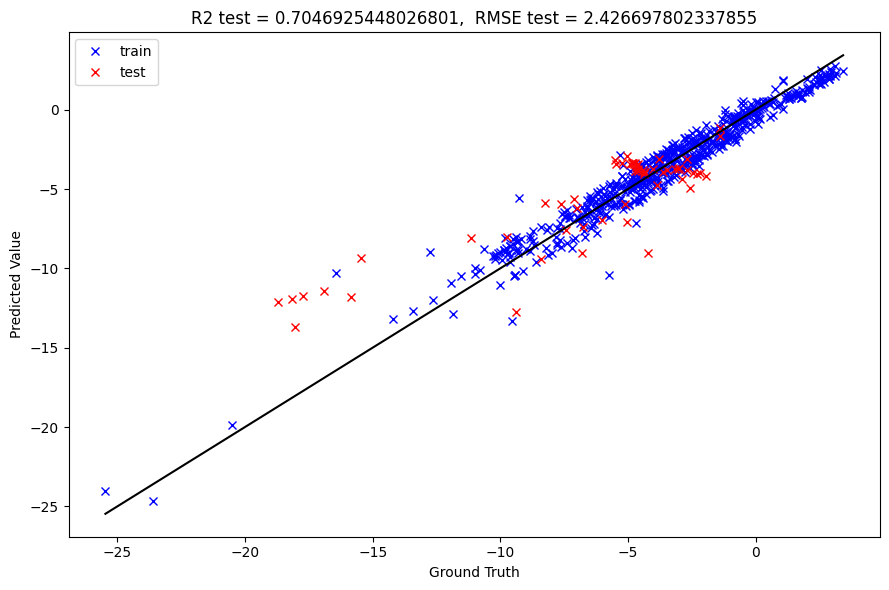

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
y_train_predictions = svr_random.best_estimator_.predict(X_train_scaled)
y_test_predictions = svr_random.best_estimator_.predict(X_test_scaled)

test_r2 = r2_score(y_test,y_test_predictions)
test_rmse = root_mean_squared_error(y_test,y_test_predictions)

ax.plot(y_train, y_train_predictions, color = 'b', linestyle='', marker='x', label='train')
ax.plot(y_test, y_test_predictions, color = 'r', linestyle='', marker='x', label='test')

ax.set_xlabel('Ground Truth')
ax.set_ylabel('Predicted Value')
ax.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], color = 'k')
ax.set_title(f'R2 test = {test_r2},  RMSE test = {test_rmse}')
ax.legend(loc='best')
fig.tight_layout()
fig.show()
fig.savefig('best_svr_model.png',dpi=200)


SVR model seems most robust, let's save that.

In [ ]:
from src.models.molecular_sklearn_regressor import MolecularSKLearnRegressor
from pathlib import Path

best_model = MolecularSKLearnRegressor(sklearn_regressor=svr_random.best_estimator_, 
                                       molecule_transformer=transformer, 
                                       scaler=scaler)

assert all(np.isclose(y_test_predictions,best_model.predict(X_raw=X_test)))

rootpath = Path('../models')
best_model.save_model(rootpath)

best_model_reloaded = MolecularSKLearnRegressor.from_pretrained(rootpath/'sklearn_model.pkl', 
                                                                rootpath/'featurizer_state_dict.yml',
                                                                rootpath/'scaler.pkl')

assert all(np.isclose(y_test_predictions,best_model_reloaded.predict(X_raw=X_test)))
